In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import time
import math
from IPython import display

In [2]:
df = pd.read_csv('ticker_data_preprocessed.csv', index_col=0)
print(df.shape)
df.head()

(482, 1196)


,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,sector
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011652,...,-0.019737,-0.012955,-0.016524,-0.007316,-0.009475,-0.005723,0.017351,-0.007921,-0.009695,Healthcare
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,-0.016889,-0.052971,-0.039305,-0.039339,-0.028665,0.034570,0.039120,-0.039216,-0.017143,Industrials
AAP,0.009049,0.036899,0.010631,-0.007042,-0.008080,0.000905,0.021340,0.026472,-0.017595,0.012730,...,-0.013735,-0.002231,-0.008399,-0.021997,-0.017570,0.010337,0.025171,-0.022410,-0.020794,Consumer Cyclical
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000115,-0.000229,0.005680,0.010326,-0.005082,0.016516,...,0.015665,-0.020268,-0.006375,-0.015124,0.002260,0.006566,-0.012652,-0.049119,-0.030039,Technology
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007538,-0.005487,-0.004213,0.010779,0.021427,0.018246,...,-0.006239,-0.010298,0.019243,0.000350,-0.012932,0.003612,0.020322,-0.013001,-0.059627,Healthcare


In [3]:
df_pct = df.drop(['sector'], axis=1).T
df_pct.index = pd.to_datetime(df_pct.index)
stock_names = df_pct.columns
# df_pct = df_pct.T.reset_index(drop=True)

df_pct.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2018-01-03,0.025444,-0.012266,0.009049,-0.000174,0.015649,0.003722,0.017300,0.002211,0.004615,0.012406,...,-0.010834,-0.006693,0.019640,-0.003426,0.012193,-0.000858,0.006932,0.019863,-0.001183,0.004598
2018-01-04,-0.007501,0.006305,0.036899,0.004645,-0.005703,-0.002225,0.017516,-0.001697,0.011841,-0.001094,...,0.005415,-0.007791,0.001384,-0.000149,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964
2018-01-05,0.015988,-0.000380,0.010631,0.011385,0.017408,0.012104,0.015408,0.002890,0.008249,0.004053,...,0.006671,-0.007003,-0.000806,0.014051,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444
2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,0.027086,-0.002882,0.007991,0.001745,...,-0.013314,0.007480,0.004496,0.006781,0.003611,0.001690,0.001905,0.009951,-0.004914,0.011996
2018-01-09,0.024554,-0.000959,-0.008080,-0.000115,0.007538,0.006398,0.009432,0.001700,0.003335,-0.002069,...,0.006778,-0.011667,-0.004246,-0.041728,0.000288,-0.002651,-0.016083,0.030643,0.023509,0.011719


In [4]:
df_train = df_pct[pd.to_datetime(df_pct.index) < datetime(2020,1,1)]
df_test = df_pct[(pd.to_datetime(df_pct.index) >= datetime(2020,1,1))]#&(df_pct.index != max(df_pct.index))]

# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

df_train = df_train.T.reset_index(drop=True)
df_test = df_test.T.reset_index(drop=True)

In [5]:
df_train.shape, df_test.shape

((482, 502), (482, 693))

In [6]:
df_train

,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
0,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011652,...,-0.005921,-0.006194,0.012945,0.008046,0.000822,0.000469,0.001758,-0.000351,-0.006088,0.004829
1,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.012894,-0.009901,0.019643,0.017163,0.008953,-0.004096,0.016792,-0.041456,-0.004923,0.013428
2,0.009049,0.036899,0.010631,-0.007042,-0.008080,0.000905,0.021340,0.026472,-0.017595,0.012730,...,0.029186,0.000317,-0.009808,0.010481,0.011700,0.003751,-0.008096,-0.005776,0.004863,0.006536
3,-0.000174,0.004645,0.011385,-0.003714,-0.000115,-0.000229,0.005680,0.010326,-0.005082,0.016516,...,0.001965,-0.002389,0.001001,-0.002071,0.016318,0.000951,0.019840,-0.000379,0.005935,0.007307
4,0.015649,-0.005703,0.017408,-0.016022,0.007538,-0.005487,-0.004213,0.010779,0.021427,0.018246,...,0.007268,-0.008326,-0.006269,0.005858,0.010751,-0.004432,-0.000223,-0.007013,-0.007623,0.000226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,-0.000858,0.010180,0.005828,0.001690,-0.002651,-0.002537,-0.000727,0.013699,-0.008252,0.001929,...,-0.012588,-0.008834,0.010938,0.007714,-0.007754,0.005210,0.014552,0.001081,-0.012365,0.000894
478,0.006932,-0.001441,0.009941,0.001905,-0.016083,-0.013367,-0.001959,-0.001554,-0.003440,0.006657,...,-0.000933,-0.006539,-0.000537,0.010215,0.006120,-0.002446,-0.003778,-0.001929,-0.008399,0.006252
479,0.019863,0.019760,0.015576,0.009951,0.030643,0.006666,0.055672,0.016341,0.001868,0.003242,...,-0.007868,0.007852,-0.009004,-0.002528,0.016793,-0.009348,0.000354,0.006210,-0.007383,0.005234
480,-0.001183,0.004147,0.000393,-0.004914,0.023509,0.010423,0.014518,0.003201,-0.007132,0.007939,...,0.006251,-0.003106,0.002726,0.002719,-0.005617,0.003701,0.002523,-0.003097,0.005243,0.002897


In [7]:
new_df = pd.DataFrame([np.array([[i] * 502 for i in range(482)]).flatten(), np.array([i for i in df_train.columns]*482).flatten(), df_train.values.flatten()]).T
new_df.columns = ['id', 'date', 'value']

In [8]:
new_df['position'] = new_df.groupby('id').cumcount() + 1

In [9]:
new_df.head()

,id,date,value,position
0,0,2018-01-03,0.025444,1
1,0,2018-01-04,-0.007501,2
2,0,2018-01-05,0.015988,3
3,0,2018-01-08,0.002146,4
4,0,2018-01-09,0.024554,5


In [10]:
history = {}
time_history = df_train.columns
for i, row in df_train.iterrows():
    history[i] = list(row)

In [71]:
class TSDataset(Dataset):
    def __init__(self, df, history, time_history):
        self.df = df
        self.history = history
        self.time_history = time_history

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        position = row['position']
        idx = row['id']
        past_values = self.history[idx][:position] + [0] * (502 - len(self.history[idx][:position]))
        past_dates = self.time_history[:position]
        # past_years = pd.Series(past_dates).dt.year.values - 2018
        past_weekdays = np.append(pd.Series(past_dates).dt.weekday.values + 1, [0] * (502 - len(self.history[idx][:position])))
        past_months = np.append(pd.Series(past_dates).dt.month.values, [0] * (502 - len(self.history[idx][:position])))
        past_days = np.append(pd.Series(past_dates).dt.day.values, [0] * (502 - len(self.history[idx][:position])))

        future_values = self.history[idx][position:] + [0] * (502 - len(self.history[idx][position:]))
        future_dates = self.time_history[position:]
        # future_years = pd.Series(future_dates).dt.year.values - 2018
        future_weekdays = np.append(pd.Series(future_dates).dt.weekday.values + 1, [0] * (502 - len(self.history[idx][position:])))
        future_months = np.append(pd.Series(future_dates).dt.month.values, [0] * (502 - len(self.history[idx][position:])))
        future_days = np.append(pd.Series(future_dates).dt.day.values, [0] * (502 - len(self.history[idx][position:])))


        return {'past_values': torch.tensor(past_values, dtype=torch.float32),
                'past_weekdays': torch.tensor(past_weekdays, dtype=int),
                'past_months': torch.tensor(past_months, dtype=int),
                'past_days': torch.tensor(past_days, dtype=int),
                'future_values': torch.tensor(future_values, dtype=torch.float32),
                'future_weekdays': torch.tensor(future_weekdays, dtype=int),
                'future_months': torch.tensor(future_months, dtype=int),
                'future_days': torch.tensor(future_days, dtype=int),}

In [72]:
train_dataset = TSDataset(new_df, history, time_history)
# test_dataset = TSDataset(df_test, '2022-05-15')

In [73]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [74]:
for batch in train_dataloader:
    print(batch['past_values'].shape)
    break

# for batch in test_dataloader:
#     print(batch['past_values'].shape)
#     break

torch.Size([16, 502])


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
device

device(type='cpu')

In [17]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

In [66]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Linear(input_dim, input_dim*hid_dim)
        # self.year_embedding = nn.Embedding(5, hid_dim)
        self.weekday_embedding = nn.Embedding(7+1, hid_dim)
        self.month_embedding = nn.Embedding(12+1, hid_dim)
        self.day_embedding = nn.Embedding(31+1, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, past_dates, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

#         pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        weekdays, months, days = past_dates
        pos_embedding = self.weekday_embedding(weekdays.to(self.device))\
                        + self.month_embedding(months.to(self.device))\
                        + self.day_embedding(days.to(self.device))

        #pos = [batch size, src len]
        noise = torch.normal(0, 0.01, size=src.shape).to(self.device) if self.training else 0

        src = self.dropout((self.tok_embedding(src + noise).view(batch_size, src_len, -1) * self.scale) + pos_embedding)

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

In [60]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Linear(output_dim, output_dim*hid_dim)
        # self.year_embedding = nn.Embedding(5, hid_dim)
        self.weekday_embedding = nn.Embedding(7+1, hid_dim)
        self.month_embedding = nn.Embedding(12+1, hid_dim)
        self.day_embedding = nn.Embedding(31+1, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, 1)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, future_dates, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

#         pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        weekdays, months, days = future_dates
        pos_embedding = self.weekday_embedding(weekdays.to(self.device))\
                        + self.month_embedding(months.to(self.device))\
                        + self.day_embedding(days.to(self.device))

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg).view(batch_size, trg_len, -1) * self.scale) + pos_embedding)

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

In [61]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, past_dates, trg, future_dates):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, past_dates, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, future_dates, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

In [75]:
INPUT_DIM = 502
OUTPUT_DIM = 502
HID_DIM = 100

In [76]:
LAYERS_grid = np.arange(1, 3)
HEADS_grid = np.arange(1, 4)
PF_DIM_grid = np.arange(20, 310, 40)
DROPOUT_grid = 0.1 * np.arange(1, 10, 2)
lr_grid = 0.1 ** np.arange(1, 5)
batch_size = 2**np.arange(4,9)

In [77]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [78]:
criterion = nn.MSELoss()

In [79]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in tqdm(enumerate(iterator), desc='TRAIN', total=len(iterator)):

        src = batch['past_values'].to(device)
        past_dates = batch['past_weekdays'].to(device), batch['past_months'].to(device), batch['past_days'].to(device)
        trg = batch['future_values'].to(device)
        future_dates = batch['future_weekdays'].to(device), batch['future_months'].to(device), batch['future_days'].to(device)

        optimizer.zero_grad()

        output, _ = model(src, past_dates, trg, future_dates)

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [80]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in tqdm(enumerate(iterator), desc='EVAL', total=len(iterator)):

            src = batch['past_values'].to(device)
            past_dates = batch['past_weekdays'].to(device), batch['past_months'].to(device), batch['past_days'].to(device)
            trg = batch['future_values'].to(device)
            future_dates = batch['future_weekdays'].to(device), batch['future_months'].to(device), batch['future_days'].to(device)

            output, _ = model(src, past_dates, trg, future_dates)

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [81]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [89]:
results = []
for ENC_LAYERS in LAYERS_grid:
    DEC_LAYERS = ENC_LAYERS
    for ENC_HEADS in HEADS_grid:
        DEC_HEADS = ENC_HEADS
        for ENC_PF_DIM in PF_DIM_grid:
            DEC_PF_DIM = ENC_PF_DIM
            for ENC_DROPOUT in DROPOUT_grid:
                DEC_DROPOUT = ENC_DROPOUT
                for lr in lr_grid:
                    enc = Encoder(INPUT_DIM,
                                  HID_DIM,
                                  ENC_LAYERS,
                                  ENC_HEADS,
                                  ENC_PF_DIM,
                                  ENC_DROPOUT,
                                  device)

                    dec = Decoder(OUTPUT_DIM,
                                  HID_DIM,
                                  DEC_LAYERS,
                                  DEC_HEADS,
                                  DEC_PF_DIM,
                                  DEC_DROPOUT,
                                  device)

                    model = Seq2Seq(enc, dec, 0, 0, device).to(device)
                    model.apply(initialize_weights)
                    LEARNING_RATE = lr

                    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

                    criterion = nn.MSELoss()

                    N_EPOCHS = 20
                    CLIP = 1

                    best_valid_loss = float('inf')

                    for epoch in range(N_EPOCHS):

                        start_time = time.time()

                        train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
                        valid_loss = evaluate(model, test_dataloader, criterion)

                        end_time = time.time()

                        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

                        if valid_loss < best_valid_loss:
                            best_valid_loss = valid_loss
                            torch.save(model.state_dict(), 'tut6-model.pt')

                        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
                        print(f'\tTrain Loss: {train_loss:.3f}')
                        print(f'\t Val. Loss: {valid_loss:.3f}')

                        if (epoch + 1) % 5 == 0:
                            test_loss = evaluate(model, test_dataloader, criterion)

                            print(f'| Test Loss: {test_loss:.3f}')

                            results.append(test_loss)
                        display.clear_output()

TRAIN:   0%|          | 0/15123 [00:00<?, ?it/s]

torch.Size([16, 502, 100])


RuntimeError: ignored

In [ ]:
len(results)

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4016])) that is different to the input size (torch.Size([4016, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([502])) that is different to the input size (torch.Size([502, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 3s
	Train Loss: 0.609 | Train PPL:   1.838
	 Val. Loss: 0.332 |  Val. PPL:   1.394


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 4s
	Train Loss: 0.101 | Train PPL:   1.106
	 Val. Loss: 0.217 |  Val. PPL:   1.242


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 3s
	Train Loss: 0.040 | Train PPL:   1.041
	 Val. Loss: 0.097 |  Val. PPL:   1.102


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 3s
	Train Loss: 0.022 | Train PPL:   1.022
	 Val. Loss: 0.071 |  Val. PPL:   1.073


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 05 | Time: 0m 3s
	Train Loss: 0.015 | Train PPL:   1.015
	 Val. Loss: 0.090 |  Val. PPL:   1.094


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 06 | Time: 0m 3s
	Train Loss: 0.011 | Train PPL:   1.011
	 Val. Loss: 0.079 |  Val. PPL:   1.082


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 07 | Time: 0m 3s
	Train Loss: 0.009 | Train PPL:   1.009
	 Val. Loss: 0.088 |  Val. PPL:   1.092


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 08 | Time: 0m 3s
	Train Loss: 0.007 | Train PPL:   1.007
	 Val. Loss: 0.100 |  Val. PPL:   1.105


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 09 | Time: 0m 4s
	Train Loss: 0.006 | Train PPL:   1.006
	 Val. Loss: 0.071 |  Val. PPL:   1.074


TRAIN:   0%|          | 0/31 [00:00<?, ?it/s]

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 | Time: 0m 3s
	Train Loss: 0.006 | Train PPL:   1.006
	 Val. Loss: 0.061 |  Val. PPL:   1.062


In [ ]:
test_loss = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

EVAL:   0%|          | 0/31 [00:00<?, ?it/s]

| Test Loss: 0.061 | Test PPL:   1.063 |


In [ ]:
past_values = torch.tensor(df_train.T[df_train.T.index < '2019-01-01'].T.values, dtype=torch.float32)
past_dates = df_train.T[df_train.T.index < '2019-01-01'].index
past_years = torch.tensor(pd.Series(past_dates).dt.year.values - 2018, dtype=int)
past_months = torch.tensor(pd.Series(past_dates).dt.month.values - 1, dtype=int)
past_days = torch.tensor(pd.Series(past_dates).dt.day.values - 1, dtype=int)

In [ ]:
src = past_values.to(device)
past_dates = past_years.to(device), past_months.to(device), past_days.to(device)

In [ ]:
embds = model.encoder(src, past_dates).mean(dim=1)
embds.shape

torch.Size([482, 100])

In [ ]:
embds = pd.DataFrame(embds.cpu().detach().numpy())
embds.index = df_pct.columns

In [ ]:
embds.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,-1.402285,-0.953449,0.774904,1.367588,-1.461878,0.809989,1.501772,-0.959305,0.722469,-1.036057,...,-0.438148,1.455077,0.092211,-0.671659,0.128230,1.310270,0.249039,-0.358807,-0.638918,-0.301931
AAL,-1.415997,-0.957895,0.793315,1.398193,-1.464939,0.830778,1.530096,-1.000905,0.732149,-1.022697,...,-0.475880,1.438594,0.074260,-0.664777,0.112955,1.306170,0.227113,-0.368324,-0.646778,-0.290909
AAP,-1.354229,-0.975257,0.785179,1.306709,-1.417849,0.749154,1.446732,-0.976729,0.684952,-1.044516,...,-0.456603,1.428453,0.112321,-0.651379,0.148979,1.299148,0.232886,-0.369314,-0.679804,-0.269383
AAPL,-1.376326,-0.965699,0.772017,1.357065,-1.460236,0.799146,1.488197,-0.961649,0.726753,-1.047789,...,-0.436573,1.445509,0.088227,-0.686277,0.142336,1.303927,0.242436,-0.356577,-0.652095,-0.302187
ABBV,-1.404136,-0.965072,0.782581,1.375905,-1.452061,0.783931,1.481459,-0.921033,0.676337,-1.012158,...,-0.449371,1.479806,0.100066,-0.635531,0.110626,1.322726,0.261595,-0.372579,-0.640143,-0.285235


In [ ]:
embds.to_csv("transformer_embs.csv")

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
a = pca.fit_transform(embds)

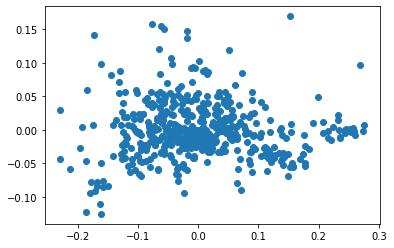

In [ ]:
plt.scatter(a[:, 0], a[:, 1])